# Praktyczne zastosowanie modeli oceny wartości relacji z klientem w czasie.

#### Wczytanie bibliotek

In [474]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import plotly.graph_objs as go
from scipy.spatial import ConvexHull
from plotly.offline import init_notebook_mode,iplot
import datetime


#### Konfiguracja

In [3]:
days_pl = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Niedziela']
months_pl = ['Styczeń', 'Luty', 'Marzec', 'Kwiecień', 'Maj', 'Czerwiec', 'Lipiec', 'Sierpień', 'Wrzesień', 'Październik', 'Listopad', 'Grudzień']

init_notebook_mode(connected=True)

plt.style.use('fivethirtyeight')

#### Wczytanie danych

In [4]:
df = pd.read_csv("./data/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


#### Analiza eksploracyjna danych

***InvoiceNo***: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. <br>
***StockCode***: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
***Description***: Product (item) name. Nominal. <br>
***Quantity***: The quantities of each product (item) per transaction. Numeric. <br>
***InvoiceDate***: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
***UnitPrice***: Unit price. Numeric, Product price per unit in sterling. <br>
***CustomerID***: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
***Country***: Country name. Nominal, the name of the country where each customer resides.

In [5]:
print(f'Liczba wierszy: {df.shape[0]} \nLiczba kolumn: {df.shape[1]}')

Liczba wierszy: 541909 
Liczba kolumn: 8


In [6]:
def summarizeDataframe( dataframe ):
    tab_info=pd.DataFrame(dataframe.dtypes).T.rename(index={0:'Column Type'})
    tab_info=tab_info.append(pd.DataFrame(dataframe.isnull().sum()).T.rename(index={0:'Missing values count'}))
    tab_info=tab_info.append(pd.DataFrame(dataframe.isnull().sum()/dataframe.shape[0]*100).T.
                            rename(index={0:'Percent of missing values'}))
    display(tab_info)

In [7]:
summarizeDataframe(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Column Type,object,object,object,int64,object,float64,object,object
Missing values count,0,0,1454,0,0,0,135080,0
Percent of missing values,0,0,0.268311,0,0,0,24.9267,0


Text(0.5, 1.0, 'Ratio of missing values per columns')

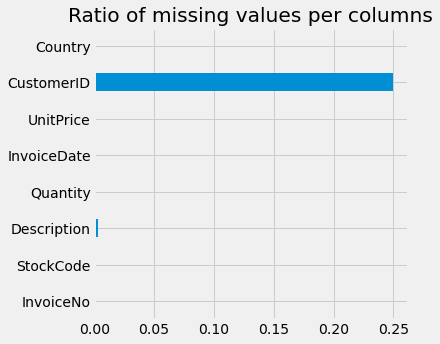

In [8]:
plt.figure(figsize=(5, 5))
df.isna().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [9]:

# Usunięcie obserwacji z brakującym "CustomerID"
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
summarizeDataframe(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Column Type,object,object,object,int64,object,float64,object,object
Missing values count,0,0,0,0,0,0,0,0
Percent of missing values,0,0,0,0,0,0,0,0


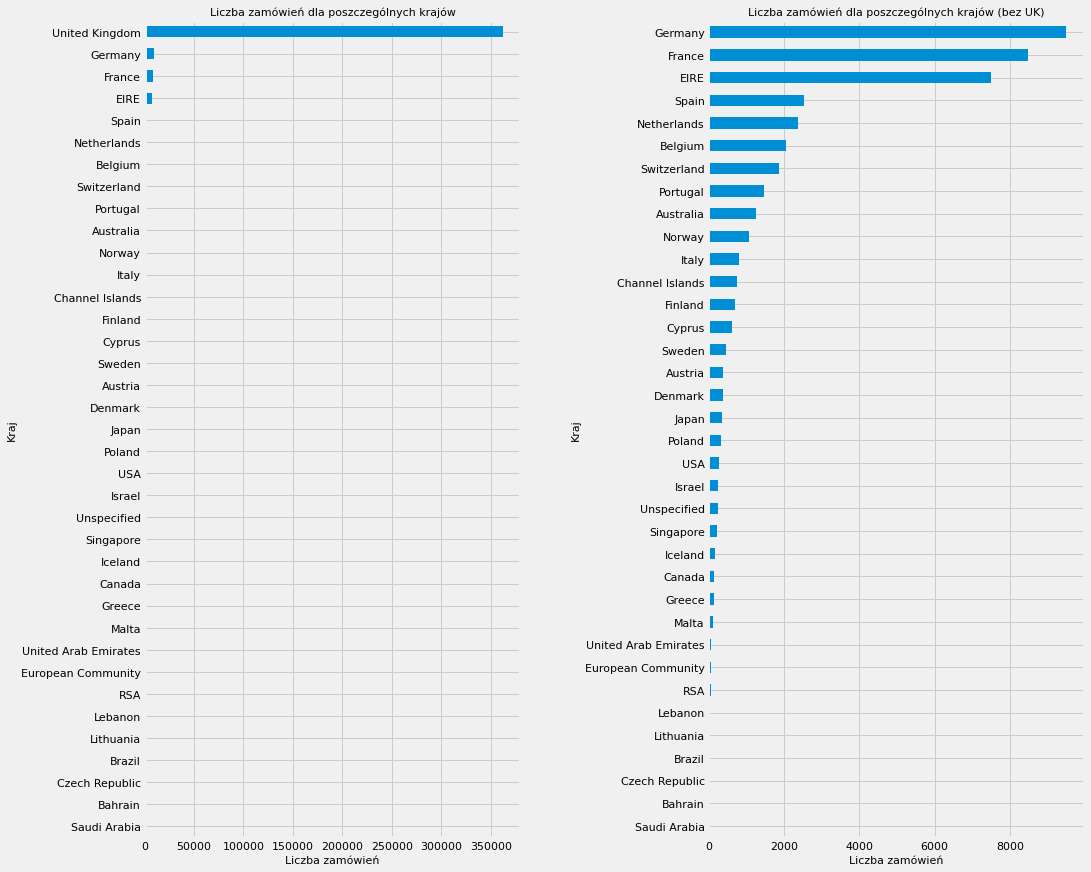

In [10]:
group_country_orders = df.groupby('Country')['InvoiceNo'].count().sort_values()

plt.figure(1 , figsize = (15 , 14))

# plot number of unique customers in each country
plt.subplot(1 , 2 , 1)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_country_orders.plot(kind='barh', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Kraj', fontsize=11)
plt.title('Liczba zamówień dla poszczególnych krajów', fontsize=11)

# plot number of unique customers in each country (without UK)
del group_country_orders['United Kingdom']
plt.subplot(1 , 2 , 2)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_country_orders.plot(kind='barh', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Kraj', fontsize=11)
plt.title('Liczba zamówień dla poszczególnych krajów (bez UK)', fontsize=11)

plt.show()

In [11]:
df['InvoiceDateFormat']=pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

df.drop("InvoiceDayOfWeek", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceDayOfWeek', value=(df.InvoiceDateFormat.dt.day_name()))
df.drop("InvoiceDayOfWeekNumber", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceDayOfWeekNumber', value=(df.InvoiceDateFormat.dt.dayofweek))

df.drop("InvoiceMonth", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceMonth', value=(df.InvoiceDateFormat.dt.month_name()))

df.drop("InvoiceYear", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceYear', value=(df.InvoiceDateFormat.dt.year))

df.drop("InvoiceHour", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceHour', value=(df.InvoiceDateFormat.dt.hour))


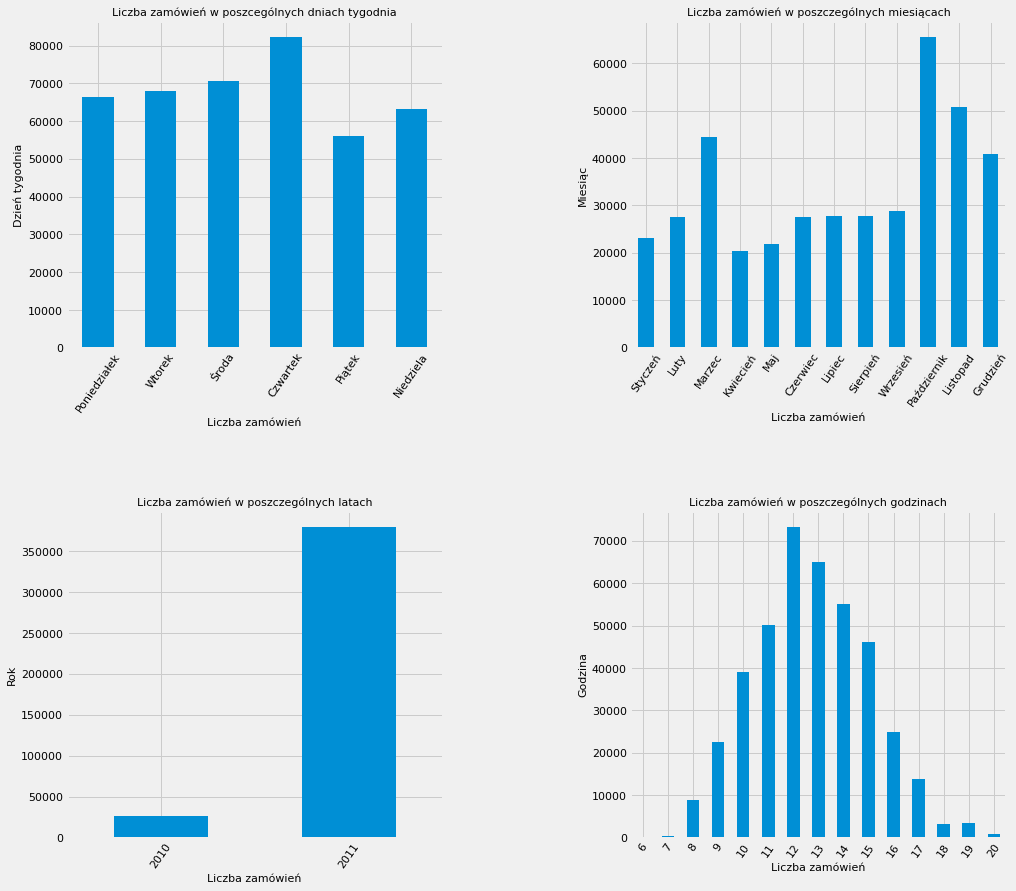

In [12]:

group_day_of_week_orders = df.groupby('InvoiceDayOfWeekNumber')['InvoiceNo'].count().sort_index()
group_month_orders = df.groupby('InvoiceMonth')['InvoiceNo'].count().sort_index()
group_year_orders = df.groupby('InvoiceYear')['InvoiceNo'].count().sort_index()
group_hour_orders = df.groupby('InvoiceHour')['InvoiceNo'].count().sort_index()

plt.figure(1 , figsize = (15 , 14))

# plot number of unique orders in each day of week
plt.subplot(2 , 2 , 1)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_day_of_week_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Dzień tygodnia', fontsize=11)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =days_pl, rotation = 55)
plt.title('Liczba zamówień w poszcególnych dniach tygodnia', fontsize=11)

# plot number of unique orders in each month
plt.subplot(2 , 2 , 2)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_month_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Miesiąc', fontsize=11)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =months_pl, rotation = 55)
plt.title('Liczba zamówień w poszczególnych miesiącach', fontsize=11)

# plot number of unique orders in each year
plt.subplot(2 , 2 , 3)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_year_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Rok', fontsize=11)
plt.xticks(rotation = 55)
plt.title('Liczba zamówień w poszczególnych latach', fontsize=11)

# plot number of unique orders in each hour
plt.subplot(2 , 2 , 4)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_hour_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Godzina', fontsize=11)
plt.xticks(rotation = 55)
plt.title('Liczba zamówień w poszczególnych godzinach', fontsize=11)

plt.show()

In [13]:
df.drop("IsInvoiceCancelled", axis=1, errors='ignore', inplace = True)
df['IsInvoiceCancelled'] = df['InvoiceNo'].apply(lambda x: ('C' in x))

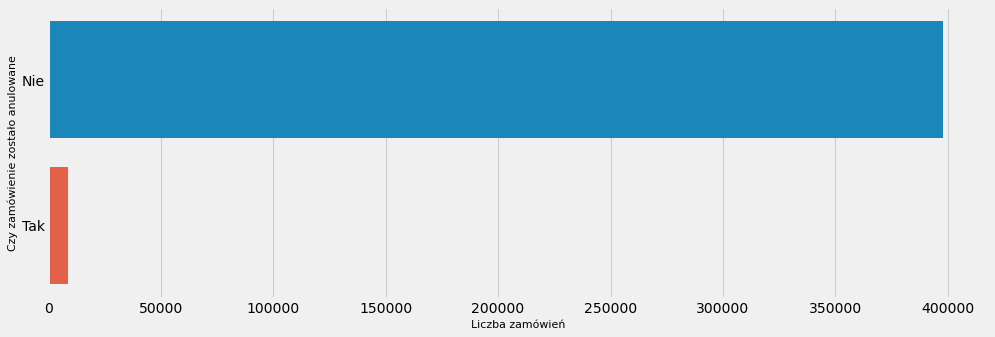

In [14]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'IsInvoiceCancelled' , data = df)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Czy zamówienie zostało anulowane', fontsize=11)
locs, labels = plt.yticks()
plt.yticks(ticks=locs, labels = ['Nie', 'Tak'])
plt.show()

In [15]:
df.drop("TotalPrice", axis=1, errors='ignore', inplace = True)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [16]:
revenue_df = df[['TotalPrice', 'InvoiceDateFormat']]
revenue_df['date'] = revenue_df['InvoiceDateFormat'].apply(lambda x: x.date())
revenue_by_date = revenue_df.groupby('date')['TotalPrice'].sum()

<ipython-input-16-1879701a72cd>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



X:\Program_Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

X:\Program_Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



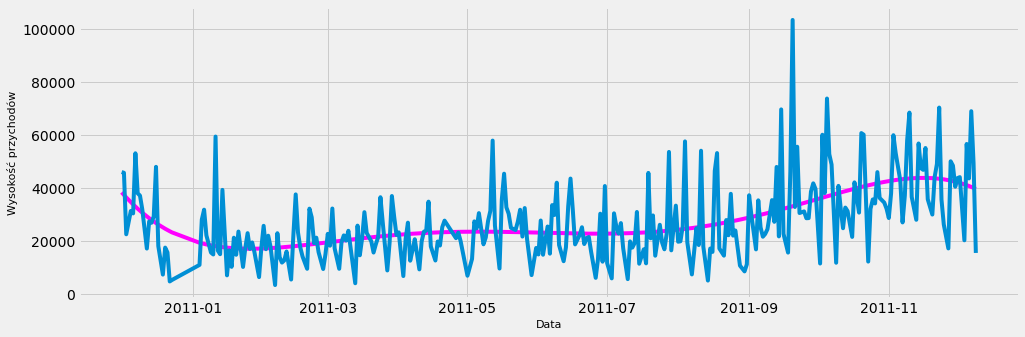

In [17]:
plt.figure(1 , figsize = (15 , 5))
z = np.polyfit(date2num(revenue_by_date.index), revenue_by_date.values, 5)
n = np.poly1d(z)(date2num(revenue_by_date.index))
# plt.plot(date2num(revenue_by_day.index), n)
# plt.plot(revenue_by_day.index, revenue_by_day.values)
sns.lineplot(date2num(revenue_by_date.index), n, color="magenta")
sns.lineplot(revenue_by_date.index, revenue_by_date.values)
plt.ylabel('Wysokość przychodów', fontsize=11)
plt.xlabel('Data', fontsize=11)
plt.show()

In [18]:
revenue_by_day = df.groupby('InvoiceDayOfWeekNumber')['TotalPrice'].sum().sort_index()

X:\Program_Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



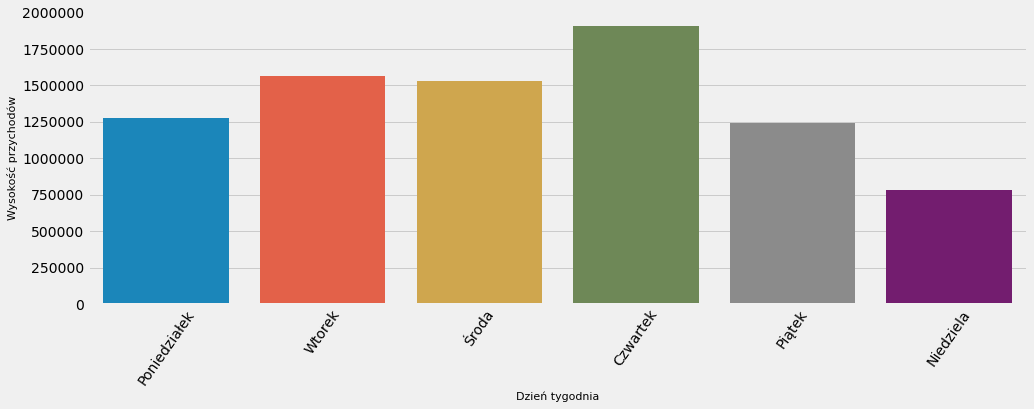

In [19]:
plt.figure(1 , figsize = (15 , 5))
sns.barplot(revenue_by_day.index, revenue_by_day.values)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =days_pl, rotation = 55)
plt.ylabel('Wysokość przychodów', fontsize=11, )
plt.xlabel('Dzień tygodnia', fontsize=11)
plt.ticklabel_format(useOffset = False, style = "plain", axis ='y')
plt.show()

<ipython-input-20-80c6787d21a9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



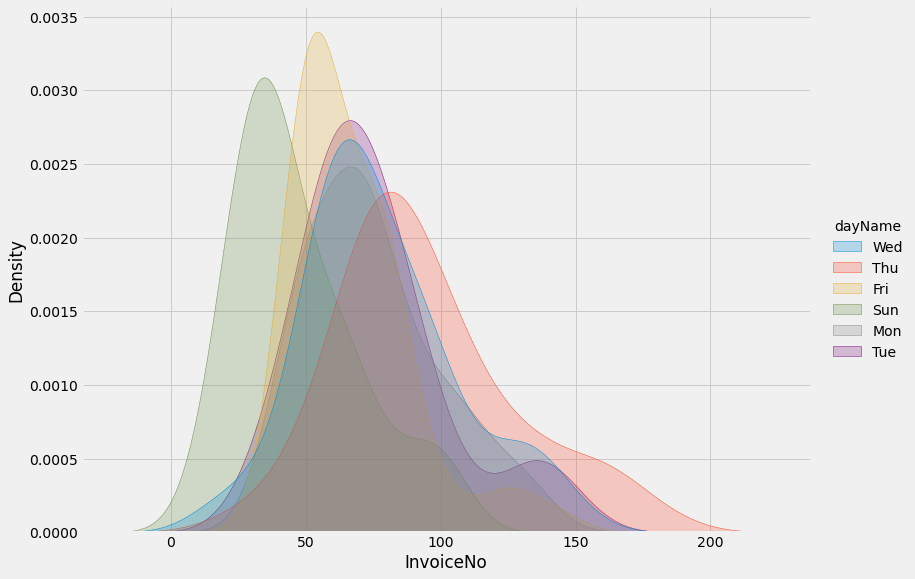

In [20]:
invoice_df = df[['InvoiceDateFormat', 'InvoiceNo']]
invoice_df['date'] = invoice_df['InvoiceDateFormat'].apply(lambda x: x.date())
invoice_count_by_day = invoice_df.groupby('date')['InvoiceNo'].nunique().reset_index()

# summarizeDataframe(invoice_count_by_day)

invoice_count_by_day['dayName'] = invoice_count_by_day['date'].apply(lambda x: x.strftime("%a"))



sns.displot(data=invoice_count_by_day, x="InvoiceNo", fill=True, hue = "dayName", kind = "kde", height=8.27, aspect=11.7/8.27)


In [21]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Ilość zamówień'},
colorscale=[[0, '#ffd1d1'],
            [0.005, '#ff9c9c'], [0.02, '#ff9c9c'],
            [1, '#fa0000']],    
reversescale = False)
#_______________________
layout = dict(title='Ilość zamówień w poszczególnych krajach', geo = dict(showframe = True, projection={'type':'equirectangular'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
choromap.update_layout(
    autosize = False,
    width = 1200,
    height = 650
)
iplot(choromap, validate=False)

### Transformacja zmiennych

In [362]:
def diff_date(x):
    print(x)
    return x

transformed_df = pd.DataFrame()
transformed_df['CustomerID'] = df['CustomerID'].unique()
total_orders_value = df.groupby('CustomerID')['TotalPrice'].sum().to_frame().rename(columns={'TotalPrice' : 'TotalOrdersValue'})
avg_order_value = df.groupby('CustomerID')['TotalPrice'].mean().to_frame().rename(columns={'TotalPrice' : 'AverageOrderValue'})
orders_count = df.groupby('CustomerID')['InvoiceNo'].nunique().to_frame().rename(columns={'InvoiceNo' : 'OrdersCount'})
min_order_value = df.groupby('CustomerID')['TotalPrice'].min().to_frame().rename(columns={'TotalPrice' : 'MinOrderValue'})
max_order_value = df.groupby('CustomerID')['TotalPrice'].max().to_frame().rename(columns={'TotalPrice' : 'MaxOrderValue'})
cancelled_orders_count = df.groupby('CustomerID')['IsInvoiceCancelled'].sum().to_frame().rename(columns={'IsInvoiceCancelled' : 'CancelledOrdersCount'})
cancelled_orders_value = df[df['IsInvoiceCancelled'] == True].groupby('CustomerID')['TotalPrice'].sum().to_frame().rename(columns={'TotalPrice' : 'CancelledOrdersValue'})
now = datetime.datetime.now()
first_order_datetime = df.groupby('CustomerID')['InvoiceDateFormat'].min()
last_order_datetime = df.groupby('CustomerID')['InvoiceDateFormat'].max()
first_order_datetime = first_order_datetime.to_frame().rename(columns={'InvoiceDateFormat' : 'DaysSinceFirstOrder'})
last_order_datetime = last_order_datetime.to_frame().rename(columns={'InvoiceDateFormat' : 'DaysSinceLastOrder'})
days_since_first_order = (now - first_order_datetime['DaysSinceFirstOrder']).dt.days
days_since_last_order = (now - last_order_datetime['DaysSinceLastOrder']).dt.days
avg_quantity = df.groupby('CustomerID')['Quantity'].mean().to_frame().rename(columns={'Quantity' : 'AverageQuantity'})
most_freq_order_day = df.groupby('CustomerID')['InvoiceDayOfWeekNumber'].agg(lambda x:x.value_counts().index[0]).to_frame().rename(columns={'InvoiceDayOfWeekNumber' : 'MostFreqOrderDay'})
most_freq_order_hour = df.groupby('CustomerID')['InvoiceHour'].agg(lambda x:x.value_counts().index[0]).to_frame().rename(columns={'InvoiceHour' : 'MostFreqOrderHour'})

transformed_df = transformed_df.merge(total_orders_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(avg_order_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(orders_count, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(min_order_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(max_order_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(cancelled_orders_count, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(cancelled_orders_value, how="left", on="CustomerID")
transformed_df = transformed_df.merge(days_since_first_order, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(days_since_last_order, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(avg_quantity, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(most_freq_order_day, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(most_freq_order_hour, how="inner", on="CustomerID")
transformed_df['CancelledOrdersValue'] = transformed_df['CancelledOrdersValue'].fillna(0)
transformed_df

,CustomerID,TotalOrdersValue,AverageOrderValue,OrdersCount,MinOrderValue,MaxOrderValue,CancelledOrdersCount,CancelledOrdersValue,DaysSinceFirstOrder,DaysSinceLastOrder,AverageQuantity,MostFreqOrderDay,MostFreqOrderHour
0,17850,5288.63,16.950737,35,-30.60,107.25,15,-102.58,4066,3995,5.426282,3,9
1,13047,3079.10,15.709694,18,-15.00,68.00,24,-158.44,4066,3724,6.913265,2,13
2,12583,7187.34,28.634821,18,-60.84,132.80,4,-94.04,4066,3695,19.956175,4,12
3,13748,948.25,33.866071,5,9.36,204.00,0,0.00,4066,3788,15.678571,0,9
4,15100,635.10,105.850000,6,-131.40,350.40,3,-240.90,4066,4022,9.666667,3,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,13436,196.89,16.407500,1,10.20,25.50,0,0.00,3694,3694,6.333333,3,10
4368,15520,343.50,19.083333,1,9.48,34.68,0,0.00,3694,3694,17.444444,3,10
4369,13298,360.00,180.000000,1,90.00,270.00,0,0.00,3694,3694,48.000000,3,13
4370,14569,227.39,18.949167,1,1.65,122.40,0,0.00,3694,3694,6.583333,3,14


### Klastryzacja

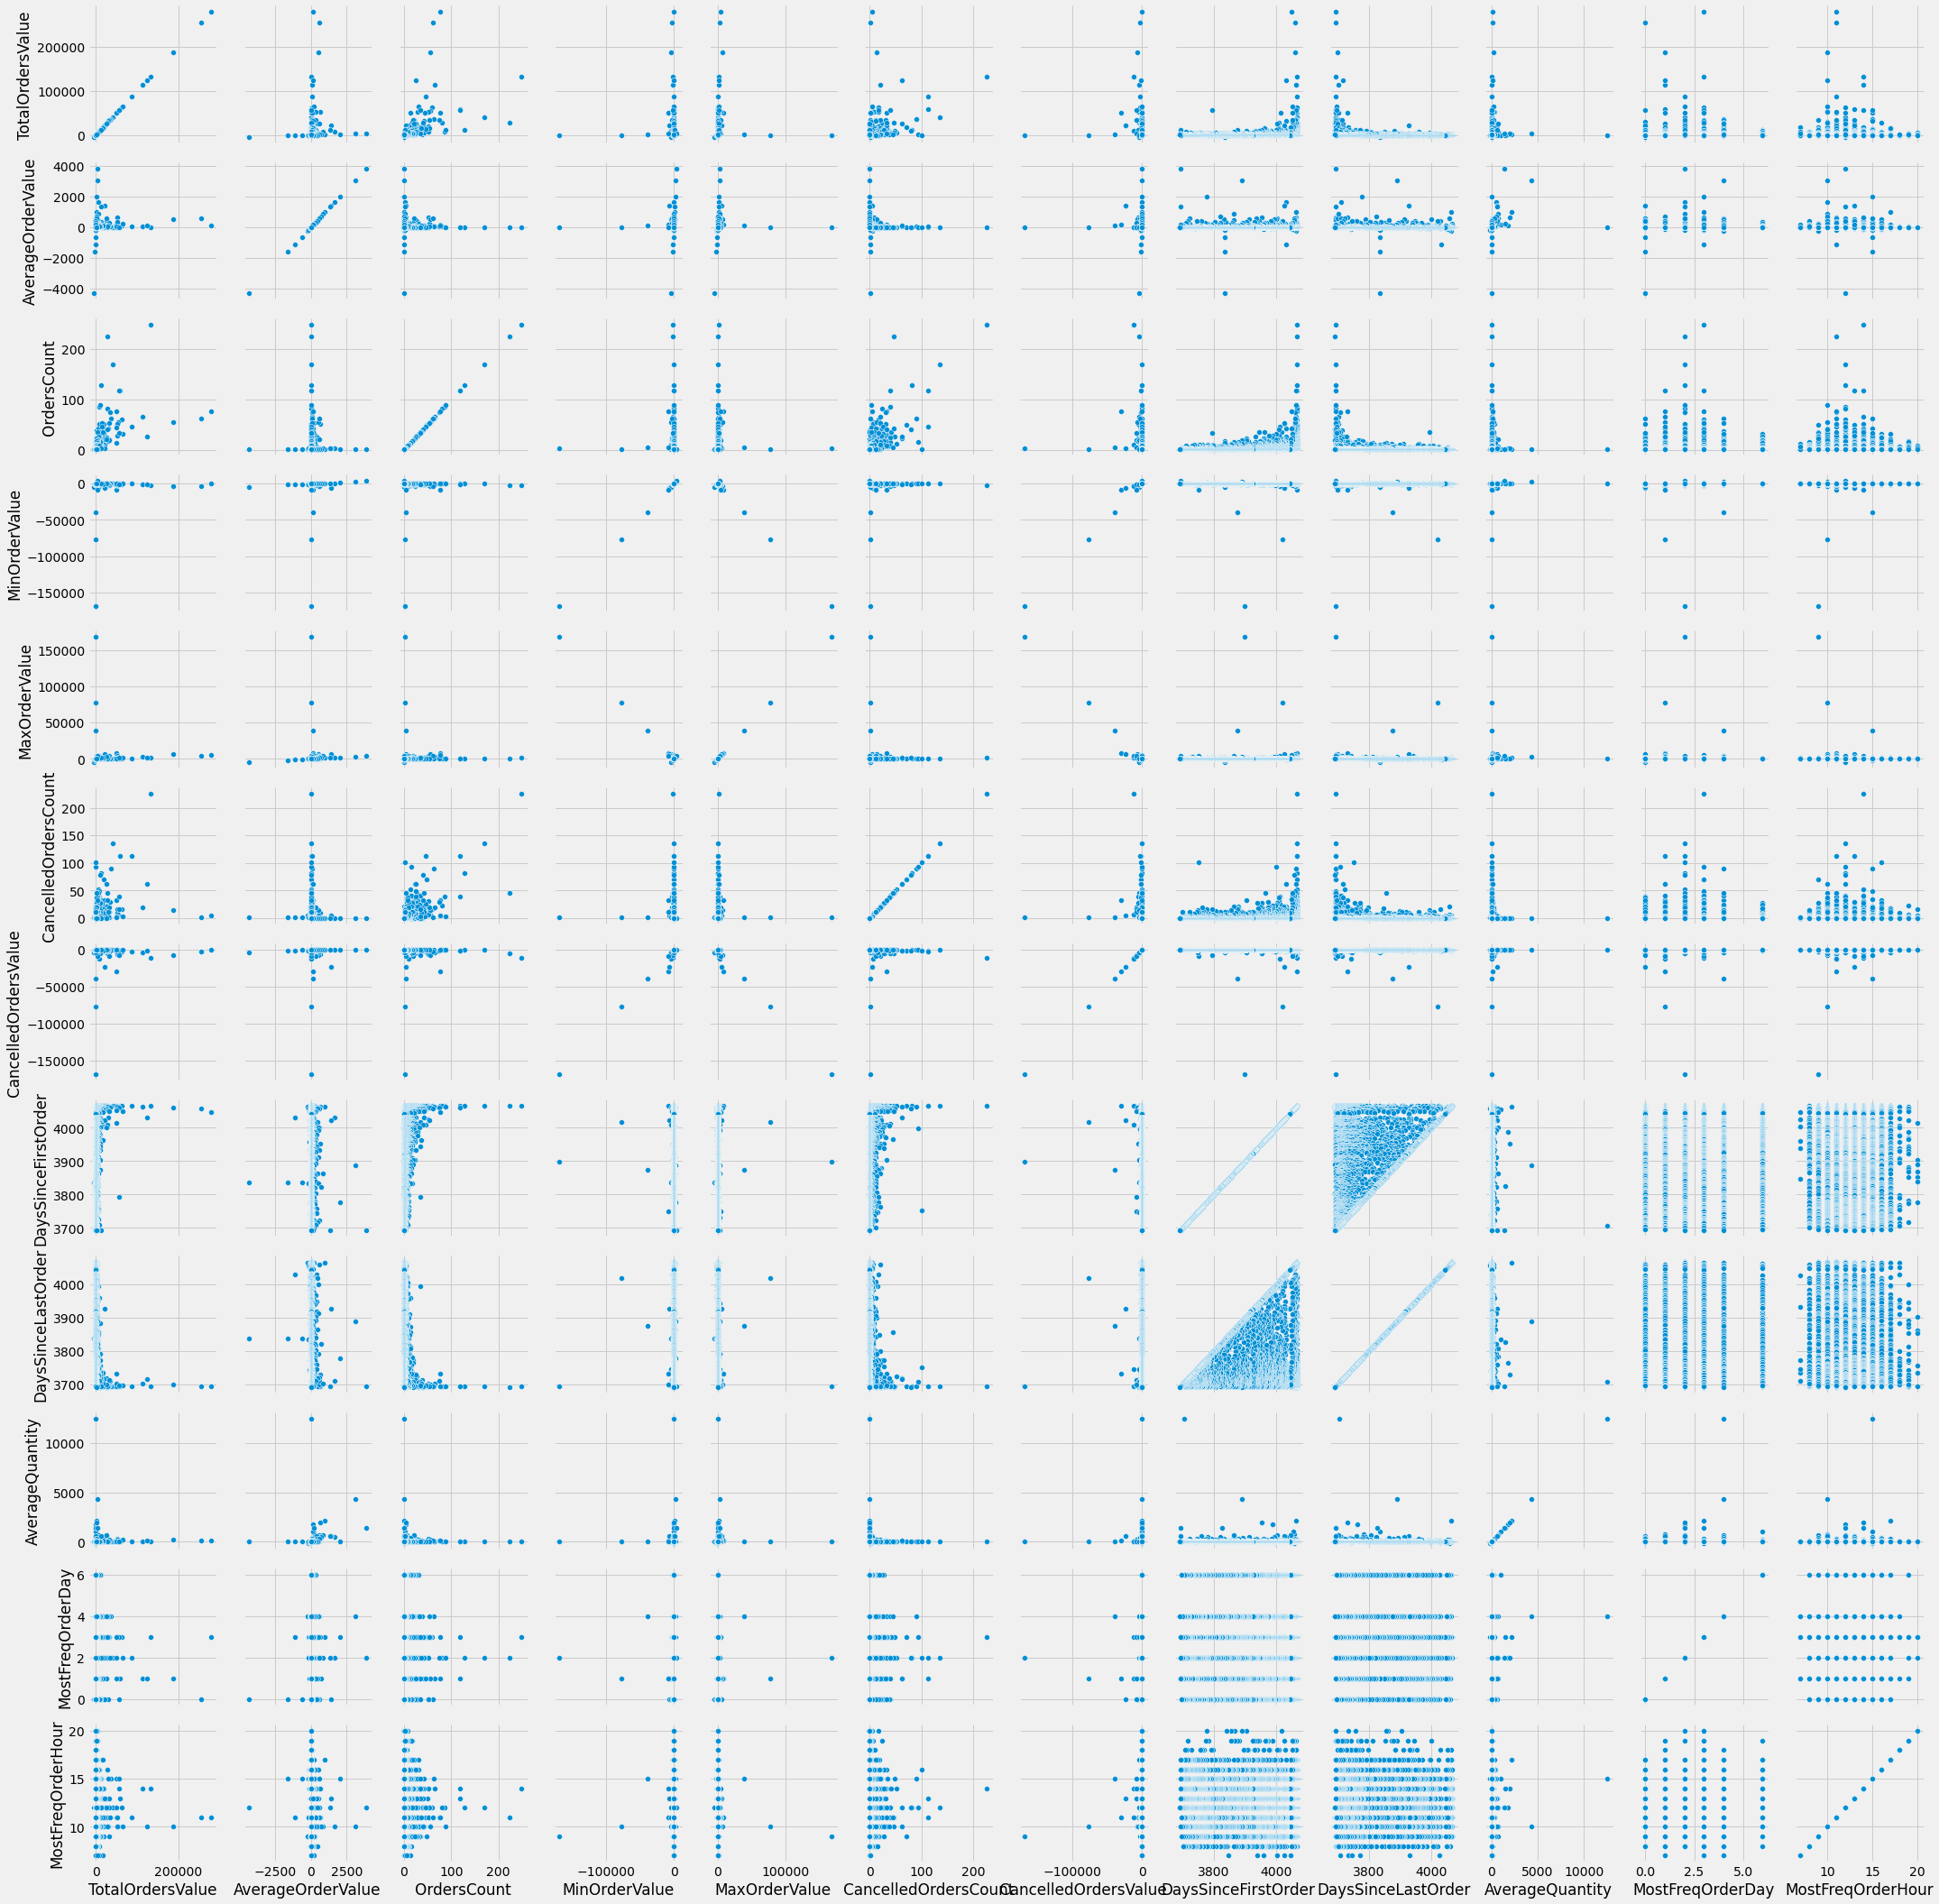

In [129]:
g = sns.PairGrid(transformed_df)
g.map(sns.scatterplot);

In [411]:
# Selekcja zmiennych, na podstawie których wykonana zostanie klasteryzacja

variable_pair = ['TotalOrdersValue', 'CancelledOrdersValue']
df_for_clustering = transformed_df[[variable_pair[0], variable_pair[1]]]
clustering_matrix = df_for_clustering.iloc[: , :].values

In [377]:
def findBestN(matrix):
    silhouette_values = pd.DataFrame( columns=['ClusterCount', 'SilhouetteValue'])
    for n in range(2,15):
        kmeans = KMeans(n_clusters = n, n_init=20, random_state=0 )
        kmeans.fit(matrix)
        clusters = kmeans.predict(matrix)
        silhouette_avg = silhouette_score(matrix, clusters)
        silhouette_values = silhouette_values.append({'ClusterCount': n, 'SilhouetteValue': silhouette_avg}, ignore_index = True)
    return silhouette_values

In [381]:
# Wyznaczenie wartości współczynnika Silhouette'a

silhouette_values = findBestN(clustering_matrix)

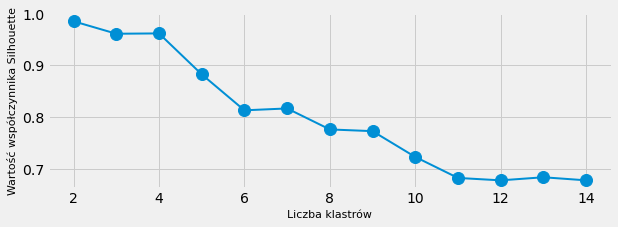

In [412]:
# Wykres wartości wspołczynnika Silhouette'a dla poszczególnej liczby klastrów

plt.figure(1 , figsize = (9 , 3) )
plt.plot(silhouette_values['ClusterCount'], silhouette_values['SilhouetteValue'], marker='o', linestyle='-', linewidth=2, markersize=12)
plt.ylabel('Wartość współczynnika Silhouette', fontsize=11, )
plt.xlabel('Liczba klastrów', fontsize=11)
plt.show()

In [460]:
# Klasteryzacja metodą K-means

best_cluster_count = 5
algorithm = (KMeans(n_clusters = best_cluster_count ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 31  , algorithm='elkan') )
algorithm.fit(clustering_matrix)
labels = algorithm.labels_
centroids = algorithm.cluster_centers_

print(centroids)

[[ 1.36026905e+03 -5.33695427e+01  1.04083409e-17]
 [ 1.14451897e+05 -4.84350250e+03  1.00000000e+00]
 [ 2.41136560e+05 -3.66814333e+03  2.00000000e+00]
 [ 3.72388073e+04 -3.15819182e+03  3.00000000e+00]
 [ 1.45000000e+00 -1.22826600e+05  4.00000000e+00]]


In [414]:
# Dodanie kolumy definiującej klaster, do którego przypisana została obserwacja

temp = []
for label in labels:
    temp.append([label])
clustering_matrix = np.append(clustering_matrix, temp, axis=1)
df_for_clustering = pd.DataFrame(clustering_matrix, columns=[variable_pair[0], variable_pair[1], 'cluster'])

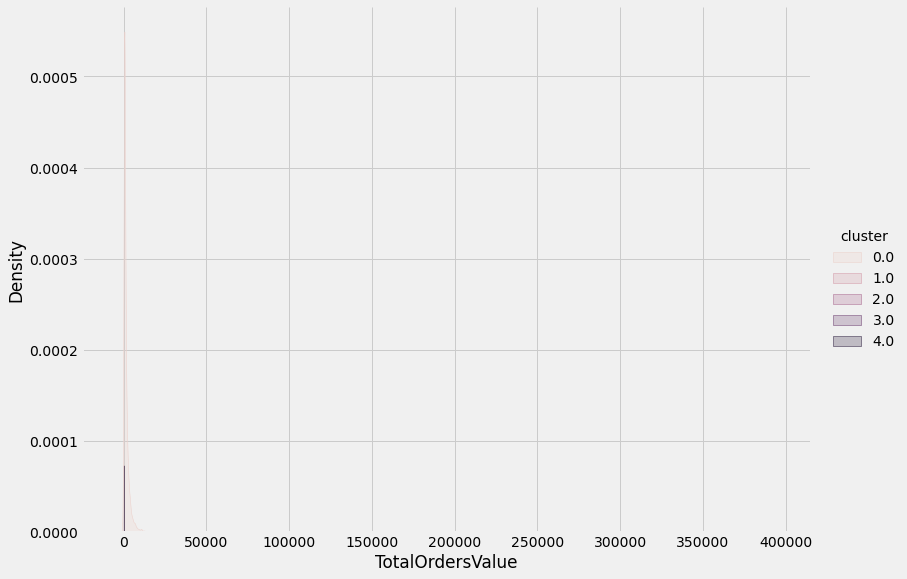

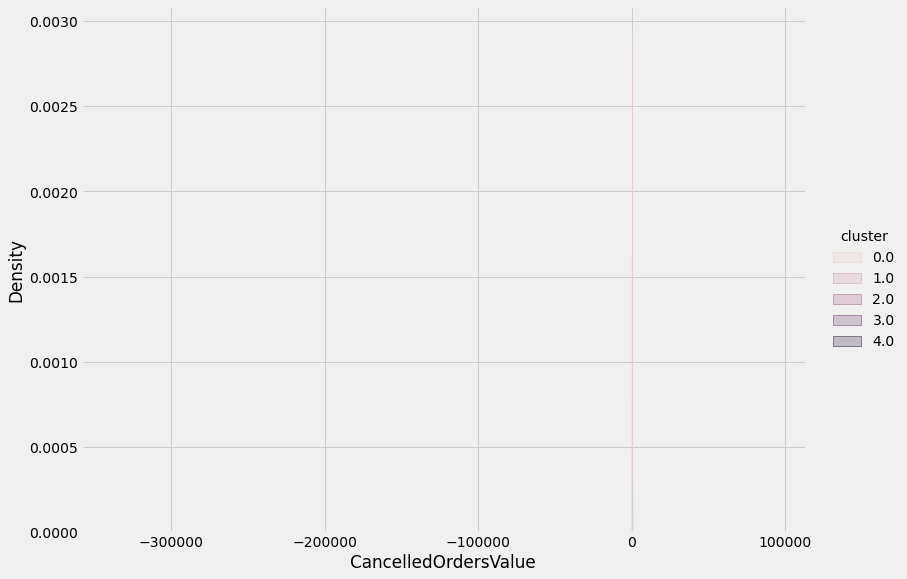

In [415]:
sns.displot(data=df_for_clustering, x=variable_pair[0], fill=True, hue = 'cluster', kind = "kde", height=8.27, aspect=11.7/8.27)
sns.displot(data=df_for_clustering, x=variable_pair[1], fill=True, hue = 'cluster', kind = "kde", height=8.27, aspect=11.7/8.27)

In [418]:
step = 20
x_min, x_max = clustering_matrix[:, 0].min() - 1, clustering_matrix[:, 0].max() + 1
y_min, y_max = clustering_matrix[:, 1].min() - 1, clustering_matrix[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

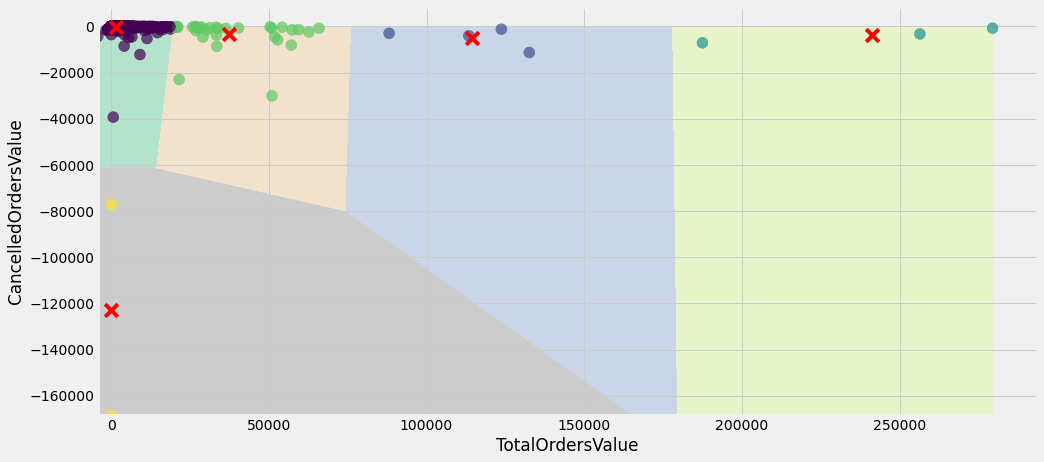

In [457]:
plt.figure(1 , figsize = (15 , 7) )
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = variable_pair[0] ,y = variable_pair[1] , data = df_for_clustering , c = labels , 
            s = 120, alpha = 0.7)
plt.scatter(x = centroids[: , 0] , y =  centroids[: , 1] , s = 160 , c = 'red' , alpha = 1, marker='x')
plt.ylabel(variable_pair[1]) , plt.xlabel(variable_pair[0])
plt.show()

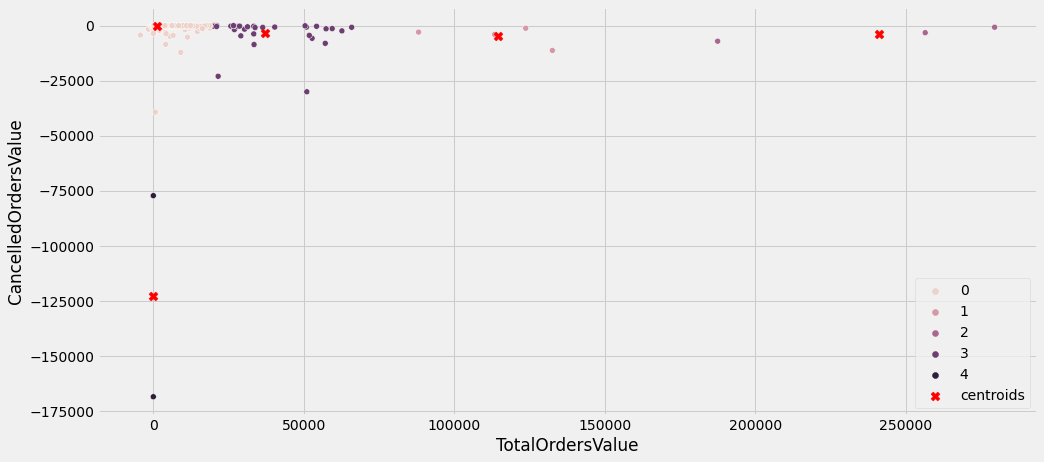

In [459]:
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
plt.figure(1 , figsize = (15 , 7) )
sns.scatterplot(x = df_for_clustering[variable_pair[0]] ,y = df_for_clustering[variable_pair[1]], hue=labels)
plt.scatter(cen_x, cen_y, 
            marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()

Text(0, 0.5, 'Defense')

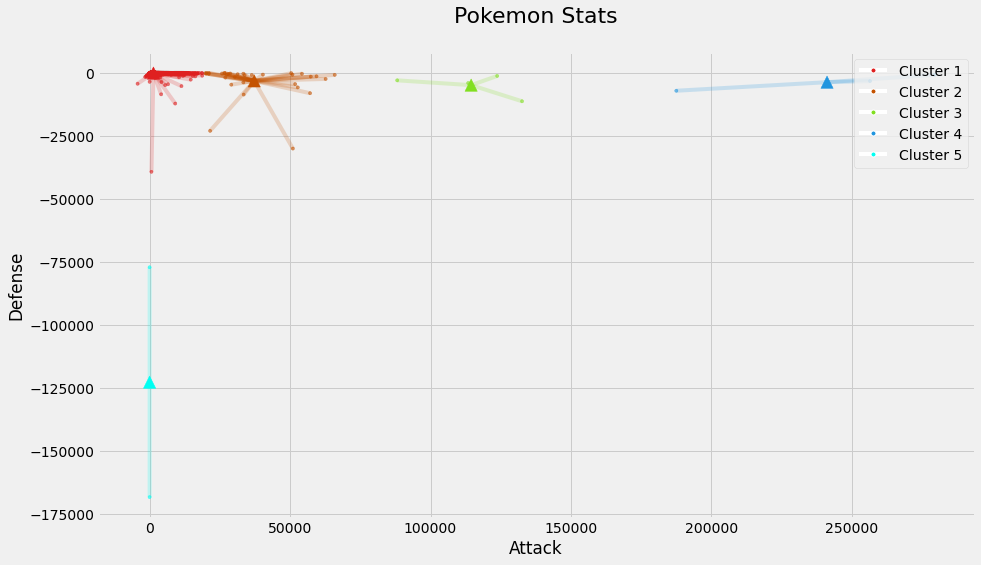

In [472]:
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF', '#c45200', '#00fff2', '#6f00ff' ]
df_for_clustering['c'] = df_for_clustering.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5]})

# plt.scatter(df_for_clustering[variable_pair[0]], df_for_clustering[variable_pair[1]], c=df_for_clustering.c, alpha = 0.6, s=10)

# ------------------------------------

#####PLOT#####
fig, ax = plt.subplots(1, figsize=(14,8))
# plot data
plt.scatter(df_for_clustering[variable_pair[0]], df_for_clustering[variable_pair[1]], c=df_for_clustering.c, alpha = 0.6, s=10)
plt.scatter(cen_x, cen_y, marker='^', c=colors[:len(df_for_clustering['c'].unique())], s=150)

# plot lines
for idx, val in df_for_clustering.iterrows():
    x = [val[variable_pair[0]], cen_x[int(val['cluster'])],]
    y = [val[variable_pair[1]], cen_y[int(val['cluster'])]]
    plt.plot(x, y, c=val.c, alpha=0.2)

# draw enclosure
for i in df.cluster.unique():
    points = df[df.cluster == i][['Attack', 'Defense']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])

# create a list of legend elemntes
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(df_for_clustering['c'].unique())]
plt.legend(handles=legend_elements, loc='upper right')
# title and labels
plt.title('Pokemon Stats\n', loc='center', fontsize=22)
plt.xlabel('Attack')
plt.ylabel('Defense')

In [ ]:
# def detectOutliers(variableName, dataframe):
#     print(dataframe)
#     dataframe.drop("outlier", axis=1, errors='ignore', inplace = True)
#     i=0
#     while i<=len(dataframe)-1:
#         quartile_1, quartile_3 = np.percentile(dataframe[variableName], [25, 75])
#         iqr = quartile_3 - quartile_1
#         lower_bound = quartile_1 - (iqr *1.5 )
#         upper_bound = quartile_3 + (iqr *1.5)
        
#         if dataframe.loc[i,variableName]> upper_bound:
#             dataframe.loc[i,'outlier']=1
#         elif dataframe.loc[i,variableName]< lower_bound:
#             dataframe.loc[i,'outlier']=1
#         else:
#             dataframe.loc[i,'outlier']=0
#         i=i+1
#     return dataframe

# test = detectOutliers(variable_pair[0], test)
# test = test.drop(test[test['outlier'] == 1].index).reset_index()

# test = detectOutliers(variable_pair[1], test)
# test = test.drop(test[test['outlier'] == 1].index).reset_index()

# test = test[variable_pair]